<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [309]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [310]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [311]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

In [312]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

<h3><font color = "#079e05"> Image </font></h3>

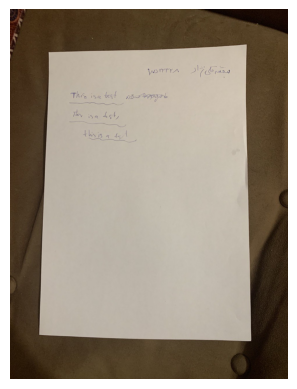

In [313]:
im = cv2.imread('images/Q4/data.jpg')
imshow(im)

<h3><font color = "#079e05"> Process </font></h3>

# Grayscale

In [314]:
def to_grayscale(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return gray

In [315]:

grayscale = to_grayscale(im)

# bluring 

In [316]:
def blur(im):
    img_blur = cv2.GaussianBlur(im, (7,7), 0) 
    return img_blur

In [317]:
blurred = blur(grayscale)


# Edge detection

In [318]:
def to_edges(im):
    edges = cv2.Canny(im,170,30)
    return edges

In [319]:
edges = to_edges(blurred)


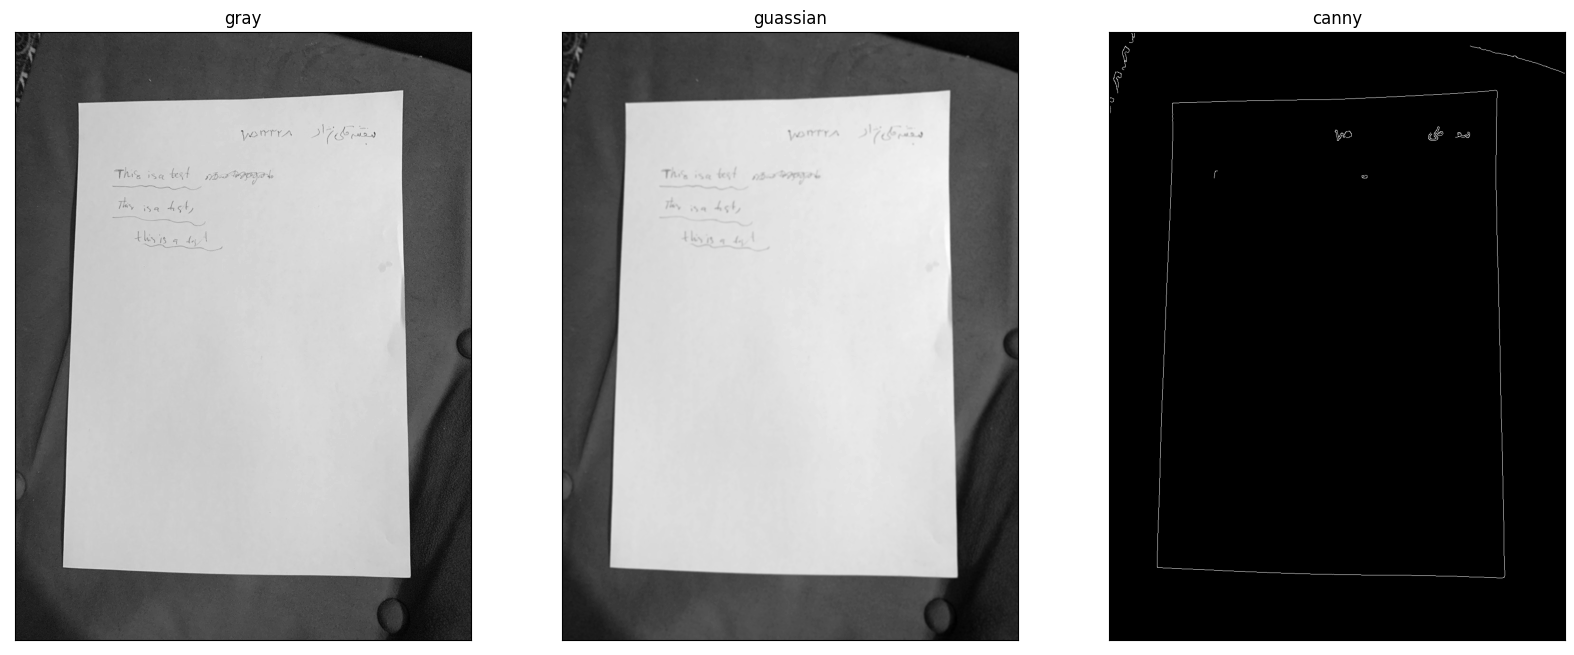

In [320]:
image_list = []

image_list.append([grayscale, 'gray', 'img'])
image_list.append([blurred, 'guassian', 'img'])
image_list.append([edges, 'canny', 'img'])
plotter(image_list,1 , 3, True, 20, 10, '2A')




# Contour Detection

In [321]:
def find_vertices(im):
    # Your code goes here.
    ret, im = cv2.threshold(im, 127, 255, 0)
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest = None
    max_area = 0
    approx_contour = None
    list = [] 
    for i in contours:
        area = cv2.contourArea(i)
        perim = 0.1* cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i,  perim, True)
        if len(approx) == 4 and area > max_area:
                biggest = approx
                max_area = area
                approx_contour = biggest
                
  

    return approx_contour
   

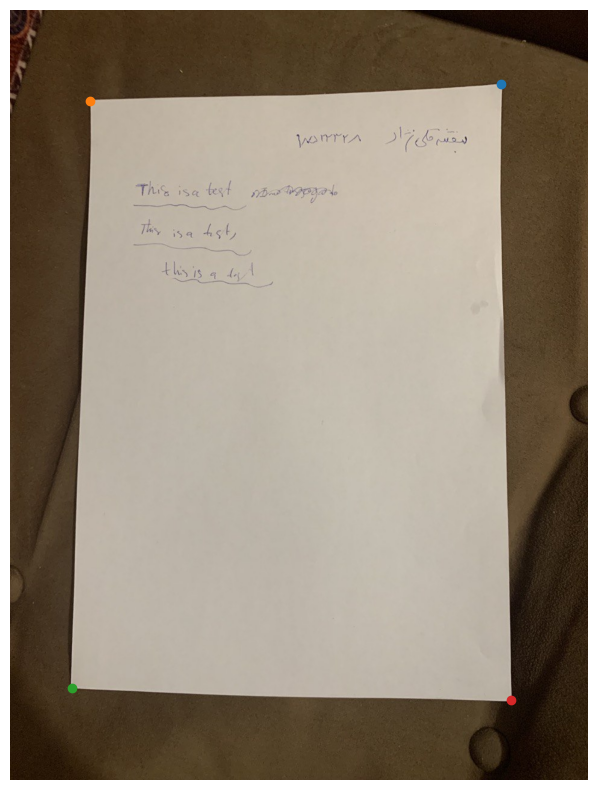

In [322]:
imshow(im)
vertices = find_vertices(edges)
for v in vertices:
    plt.scatter([x for x, y in v], [y for x, y in v])

# perspective transform 

In [323]:
def crop_out(im, vertices):
    # Your code goes here.
    w , h, *channels = im.shape 

    new_vertices = np.array([vertices[1][0],vertices[2][0],vertices[3][0], vertices[0][0]],np.float32)
    target = np.array([[0,0],[0,w],[h, w],[h,0]],np.float32)
 
    transform = cv2.getPerspectiveTransform(new_vertices, target)  # get the top or bird eye view effect
    return cv2.warpPerspective(im, transform, (h, w))

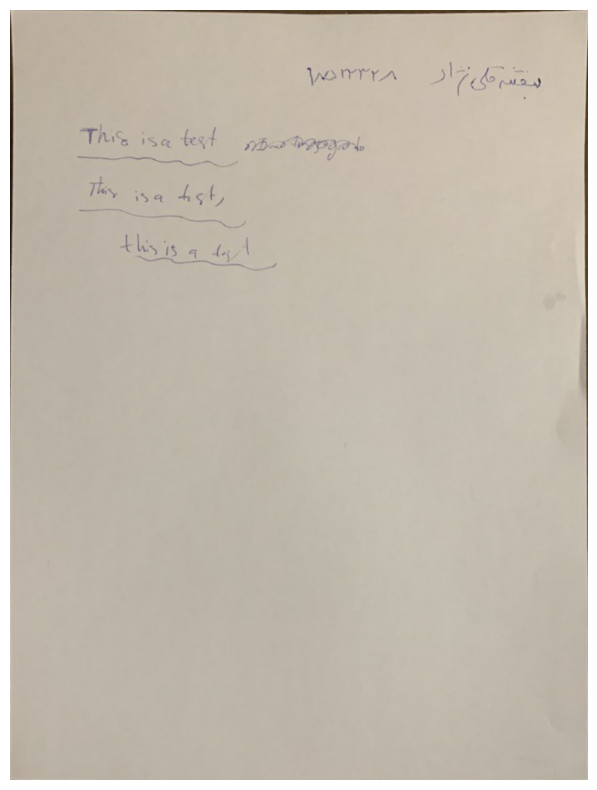

In [324]:
cropped = crop_out(im, vertices)
imshow(cropped)

# Image enhancement

In [325]:
def enhance(im):
    kernel_sharpening = np.array([[-1,-1,-1], 
                                [-1, 9,-1],
                               [-1,-1,-1]])
    sharpened = cv2.filter2D(im, -1, kernel_sharpening)
    value = 60
    hsv = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
   
  

    # Your code goes here.
    return img

<h3><font color = "#079e05"> Show the result </font></h3>

In [326]:
def scan(im):
    grayscale = to_grayscale(im)
    blurred = blur(grayscale)
    edges = to_edges(blurred)
    vertices = find_vertices(edges)
    cropped = crop_out(im, vertices)
    return enhance(cropped)

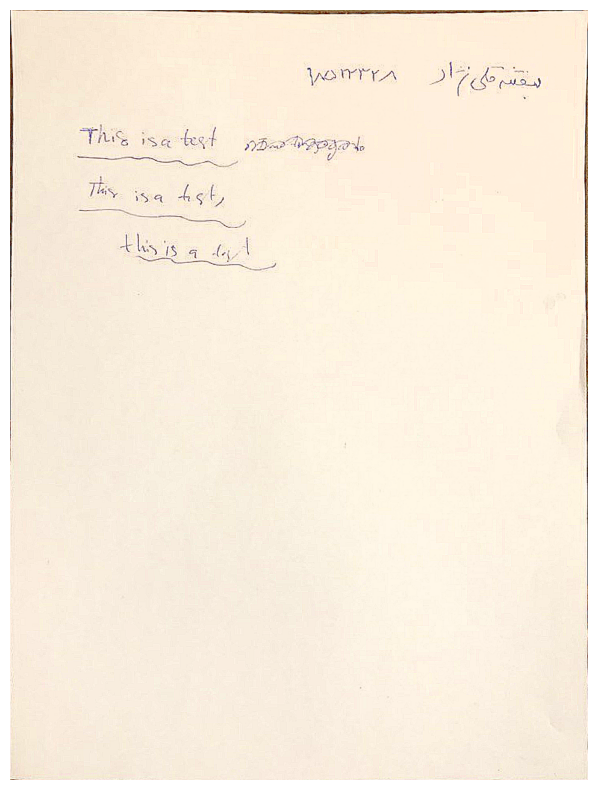

In [327]:
scanned = scan(im)
imshow(scanned)